# V2V Traffic Forecasting - ResLSTM-FC

Here we will torch.cat(ego, lead[:,300:], lead_l, res) i.e. input is 6000 samples by K*4 where K is the input length

#### Imports 

In [1]:
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import torch
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### Functions

In [2]:
def get_data(file):
    '''
    Description: Convert file into ego and lead distance, time, velocity
    Parameters: input string 
    '''
    x = loadmat(file)
    s = x['s']
    t = x['t']
    v = x['v']
    ego_s = (s[:,0])[0]
    ego_t = (t[:,0])[0]
    ego_v = (v[:,0])[0]
    lead_s = (s[:,1])[0]
    lead_t = (t[:,1])[0] 
    lead_v = (v[:,1])[0]
    ego_s = ego_s.ravel()
    lead_s = lead_s.ravel()
    ego_t = ego_t.ravel()
    lead_t = lead_t.ravel()
    ego_v = ego_v.ravel()
    lead_v = lead_v.ravel()
    return ego_s, lead_s, ego_t, lead_t, ego_v, lead_v

def interpolate(e_s, l_s, e_t, l_t, e_v, l_v, size):
    '''
    Description: Interpolate data to fit 'size' time steps
    Parameters: outputs of get_data, and 'size' number of time steps
    '''
    from scipy import interpolate
    step_size  = (e_t[-1]-e_t[0])/size
    f = interpolate.interp1d(e_t, e_s)
    ego_t = np.arange(e_t[0],e_t[-1],step_size)
    ego_s = f(ego_t)
    f2 = interpolate.interp1d(l_t,l_s)
    lead_t = np.arange(l_t[0],l_t[-1],step_size)
    lead_s = f2(lead_t)
    f3 = interpolate.interp1d(e_t, e_v)
    ego_v = f3(ego_t)
    f4 = interpolate.interp1d(l_t,l_v)
    lead_v = f4(lead_t)
    return ego_s, lead_s, ego_t, lead_t, ego_v, lead_v

def rolling_window(window_size, time_start, ego_v, lead_v, ego_t, ego_s, lead_s):
    '''
    Description: Create rolling windows samples
    Parameters: size of window, time step starting point, ego and lead velocity
    '''
    #Initialize Empty Arrays
    inputs = np.zeros((num_samples,K))                            # inputs to the network
    labels = np.zeros((num_samples, future_len))                  # labels to the network
    ego_list = np.zeros((num_samples,K))                          # ego velocity from D-K to D
    lead_list = np.zeros((num_samples,K))                         # lead velocity from B-K to B
    ego_list_label = np.zeros((num_samples, future_len))          # ego labels from D to F
    lead_list_label = np.zeros((num_samples, future_len))         # lead labels from B to E
    
    for counter, time_start in enumerate(tqdm(range(time_start,time_start+num_samples))):
        time_step_end = time_start + window_size
        wave_y = -5*(np.arange(0,np.round(ego_t[time_step_end],decimals=1),0.1)-ego_t[time_step_end]) + ego_s[time_step_end]
        #Intercept points refer to the points illustrated above
        B = np.argmin(np.abs(lead_s[0:time_step_end] - wave_y))
        D = np.argmin(np.abs(ego_s[0:time_step_end] - wave_y)) # time step end
        E = B + future_len
        F = D + future_len
        ego_list[counter] = ego_v[D-K:D]
        lead_list[counter] = lead_v[B-K:B]
        ego_list_label[counter] = ego_v[D:F]
        lead_list_label[counter] = lead_v[B:E]
        inputs[counter] = lead_v[B-K:B] - ego_v[D-K:D]
        labels[counter] = lead_v[B:E] - ego_v[D:F]
    #Convert to Tensor
    ego_list = torch.Tensor(ego_list)
    lead_list = torch.Tensor(lead_list)
    ego_list_label = torch.Tensor(ego_list_label)
    lead_list_label = torch.Tensor(lead_list_label)
    inputs = torch.Tensor(inputs)
    labels = torch.Tensor(labels)
    return ego_list, lead_list, ego_list_label, lead_list_label, inputs, labels

def normalization(inputs, labels):
    '''
    Description: Normalize the inputs and labels
    Parameters: inputs and the labels to network
    '''
    input_mean = torch.mean(inputs,1,True) 
    std = torch.std(inputs)     
    inputs_norm = (inputs - input_mean)/std           
    labels_norm = (labels - input_mean)/std
    return inputs_norm, labels_norm, input_mean, std

def train_val_test_split(K, future_len, combined, train_size, val_size, test_size, c_size):
    '''
    Description: Split data into train, test, val
    Parameters: sizes of each section, K, future output, and the combined matrix
    '''   
    train_matrix = torch.zeros((train_size,c_size))
    val_matrix = torch.zeros((val_size,c_size))
    test_matrix = torch.zeros((test_size,c_size))
    train_matrix[:1500] = combined[:1500]
    train_matrix[1500:5100] = combined[5400:9000]
    train_matrix[5100:7200] = combined[12900:15000]
    train_matrix = train_matrix[torch.randperm(train_matrix.size()[0])]
    val_matrix[:1200] = combined[3700:4900]
    val_matrix[1200:2400] = combined[11200:12400]
    val_matrix = val_matrix[torch.randperm(val_matrix.size()[0])]
    test_matrix[:1200] = combined[2000:3200]
    test_matrix[1200:2400] = combined[9500:10700]
    
    ego_train = train_matrix[:,:K]
    ego_trainl = train_matrix[:,2*K:2*K + future_len]
    ego_val = val_matrix[:,:K]
    ego_vall = val_matrix[:,2*K:2*K + future_len]
    ego_test = test_matrix[:,:K]
    ego_testl = test_matrix[:,2*K:2*K + future_len]
    lead_train = train_matrix[:,K:2*K]
    lead_trainl = train_matrix[:,2*K + future_len:2*K + 2*future_len]
    lead_val = val_matrix[:,K:2*K]
    lead_vall = val_matrix[:,2*K + future_len:2*K + 2*future_len]
    lead_test = test_matrix[:,K:2*K]
    lead_testl = test_matrix[:,2*K + future_len:2*K + 2*future_len]
    res_train = train_matrix[:,2*K + 2*future_len:3*K + 2*future_len]
    res_trainl = train_matrix[:, 3*K + 2*future_len: 3*K + 3*future_len]
    res_val = val_matrix[:,2*K + 2*future_len:3*K + 2*future_len]
    res_vall = val_matrix[:, 3*K + 2*future_len: 3*K + 3*future_len]
    res_test = test_matrix[:,2*K + 2*future_len:3*K + 2*future_len]
    res_testl = test_matrix[:, 3*K + 2*future_len: 3*K + 3*future_len]
    res_mean_train = train_matrix[:,-1]
    res_mean_val = val_matrix[:,-1]
    res_mean_test = test_matrix[:,-1]
    res_mean = torch.unsqueeze(torch.cat([res_mean_train,res_mean_val,res_mean_test],0),1)    
    return ego_train,ego_trainl,ego_val,ego_vall,ego_test,ego_testl,lead_train,lead_trainl,lead_val,lead_vall,lead_test,lead_testl,res_train,res_trainl,res_val,res_vall,res_test,res_testl, res_mean



#### Set Up Data 

In [3]:
interpol_size = 10000
num_samples = 7500
window_size = 1000
time_start = 500
K = 600
future_len = window_size - K
train_size = 7200
val_size = 2400
test_size = 2400
c_size = 3*(K+future_len) + 1

# Load Data
e_s_1, l_s_1, e_t_1, l_t_1, e_v_1, l_v_1 = get_data('Dataset1.mat')
e_s_5, l_s_5, e_t_5, l_t_5, e_v_5, l_v_5 = get_data('Dataset3.mat')
# Interpolate
ego_s_1, lead_s_1, ego_t_1, lead_t_1, ego_v_1, lead_v_1 = interpolate(e_s_1, l_s_1, e_t_1, l_t_1, e_v_1, l_v_1, interpol_size)
ego_s_5, lead_s_5, ego_t_5, lead_t_5, ego_v_5, lead_v_5 = interpolate(e_s_5, l_s_5, e_t_5, l_t_5, e_v_5, l_v_5, interpol_size)
# Rolling Window
ego_1, lead_1, ego_l_1, lead_l_1, res_1, res_l_1 = rolling_window(window_size, time_start, ego_v_1, lead_v_1, ego_t_1, ego_s_1, lead_s_1)
ego_5, lead_5, ego_l_5, lead_l_5, res_5, res_l_5 = rolling_window(window_size, time_start, ego_v_5, lead_v_5, ego_t_5, ego_s_5, lead_s_5)
ego = torch.cat((ego_1, ego_5))
lead = torch.cat((lead_1, lead_5))
ego_l = torch.cat((ego_l_1, ego_l_5))
lead_l = torch.cat((lead_l_1, lead_l_5))
res = torch.cat((res_1,res_5))
res_l = torch.cat((res_l_1, res_l_5))

# Normalize
res_norm, resl_norm, means, std = normalization(res, res_l)
# Create Combined Matrix
combined = torch.cat([ego, lead, ego_l, lead_l, res_norm, resl_norm, means],1)
# Train, Val, Test Split
ego_train,ego_trainl,ego_val,ego_vall,ego_test,ego_testl,lead_train,lead_trainl,lead_val,lead_vall,lead_test,lead_testl,res_train,res_trainl,res_val,res_vall,res_test,res_testl, res_mean = train_val_test_split(K, future_len, combined, train_size, val_size, test_size, c_size)
train = torch.cat((ego_train, lead_train[:,300:], lead_trainl, res_train),1)


100%|██████████| 7500/7500 [00:00<00:00, 8171.80it/s] 


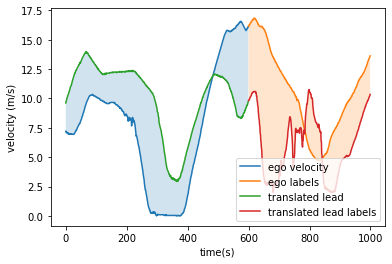

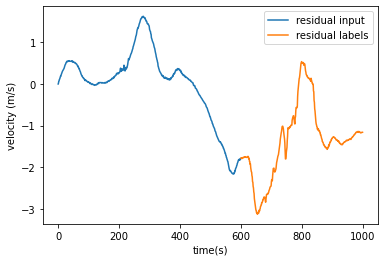

In [4]:
plt.plot(ego_train[0], label = 'ego velocity')
plt.plot(list(range(600,1000)),ego_trainl[0], label = 'ego labels')
plt.plot(lead_train[0], label = 'translated lead')
plt.plot(list(range(600,1000)),lead_trainl[0], label = 'translated lead labels')
plt.fill_between(list(range(600)),lead_train[0], ego_train[0], alpha = 0.2)
plt.fill_between(list(range(600,1000)), lead_trainl[0], ego_trainl[0], alpha = 0.2)
plt.xlabel('time(s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()
plt.plot(res_train[0], label = 'residual input')
plt.plot(list(range(600,1000)),res_trainl[0], label = 'residual labels')
plt.xlabel('time(s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

#### GPU Availability 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Network Definition

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size = 200, output_size = 400):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers = 2)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.rand(2,1,self.hidden_layer_size),
                            torch.rand(2,1,self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

#### Creating Model 

In [8]:
# model = LSTM()
model = torch.load('600K_200H_400_AVE_data1_5_table1_trial2')
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) 
print(model.parameters)

<bound method Module.parameters of LSTM(
  (lstm): LSTM(1, 200, num_layers=2)
  (linear): Linear(in_features=200, out_features=400, bias=True)
)>


In [9]:
offical = []
epoch_loss_list = []
epoch_val_loss_list = []
best_val_loss = 1.0e6
best_AVE_val = 1000

In [10]:
model.train()
epochs = 50
for i in range(epochs):
    print('epoch', i)
    epoch_loss = 0
    epoch_val_loss = 0
    for counter, seq in enumerate(tqdm(train)):
        seq = seq.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.rand(2, 1, model.hidden_layer_size).to(device),
                        torch.rand(2, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)
        label = res_trainl[counter,0:future_len].to(device)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()
        epoch_loss += single_loss.item()     
    epoch_loss_list.append(epoch_loss)
    with torch.no_grad():
        prediction_val = torch.zeros((len(res_val),future_len)).to(device)   
        for count, sample in enumerate(res_val):
            sample = sample.to(device)
            model.hidden_cell = (torch.rand(2, 1, model.hidden_layer_size).to(device),
                        torch.rand(2, 1, model.hidden_layer_size).to(device))
            val_pred = model(sample)
            val_label = res_vall[count,0:future_len].to(device)
            val_single_loss = loss_function(val_pred,val_label)
            epoch_val_loss += val_single_loss.item()
            prediction_val[count] = model(sample)
    
    prediction_val = prediction_val.cpu().detach().numpy()   
    unnorm_pred_val = (prediction_val*std.cpu().detach().numpy()) + res_mean[-test_size:].numpy()     
    final_real_val = lead_testl - torch.Tensor(unnorm_pred_val)
    AVE_val = np.mean(np.abs(np.array(ego_testl)-np.array(final_real_val)))
    if AVE_val < best_AVE_val:
        torch.save(model, "600K_200H_400_AVE_data1_5_ego_lead_leadlabels_res_trial6")
        best_AVE_val = AVE_val

    if epoch_val_loss < best_val_loss:
        torch.save(model, "600K_200H_400_data1_5_ego_lead_leadlabels_res_trial6")
        best_val_loss = epoch_val_loss

    epoch_val_loss_list.append(epoch_val_loss)


  0%|          | 1/7200 [00:00<19:12,  6.25it/s]

epoch 0


  0%|          | 20/7200 [00:02<17:02,  7.02it/s]


KeyboardInterrupt: 

#### Plot Loss

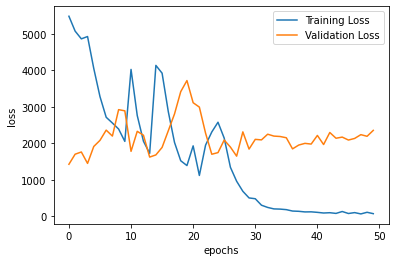

In [9]:
plt.plot(epoch_loss_list, label = 'Training Loss')
plt.plot(epoch_val_loss_list, label = 'Validation Loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

#### Generate Testing Predictions 

In [52]:
model.eval()
with torch.no_grad():
    prediction = torch.zeros((len(res_test),future_len)).to(device)   
    for i, seq in enumerate(res_test):
        seq = seq.to(device)
        model.hidden = (torch.rand(2, 1, model.hidden_layer_size).to(device),
                            torch.rand(2, 1, model.hidden_layer_size).to(device))
        prediction[i] = model(seq)
prediction = prediction.cpu().detach().numpy()

#### Visualize One Sample 

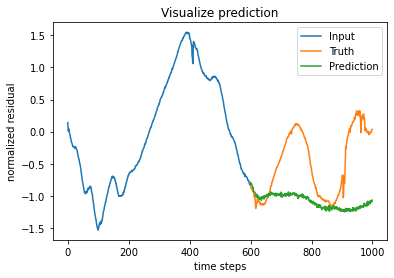

In [53]:
#Choose Sample
sample = 100

#Visualize Prediction Residual with Input
plt.plot(res_test[sample], label = "Input")
plt.plot(list(range(K,K+future_len)),res_testl[sample], label = "Truth")
plt.plot(list(range(K,K+future_len)),prediction[sample], label = "Prediction")
plt.xlabel("time steps")
plt.ylabel("normalized residual")
plt.title("Visualize prediction")
plt.legend()
plt.show()

#### Unnormalization 

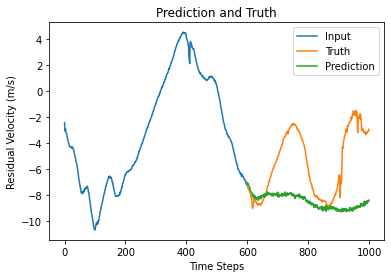

In [54]:
unnorm_pred = (prediction*std.cpu().detach().numpy()) + res_mean[-test_size:].numpy()
unnorm_label = (res_testl.cpu().detach().numpy()*std.cpu().detach().numpy()) + res_mean[-test_size:].numpy()
unnorm_input = (res_test.cpu().detach().numpy()*std.cpu().detach().numpy()) + res_mean[-test_size:].numpy()
#Plot Unnormalized Residual
plt.plot(unnorm_input[sample], label = "Input")
plt.plot(list(range(K,K+future_len)), unnorm_label[sample], label = "Truth")
plt.plot(list(range(K,K+future_len)),unnorm_pred[sample], label = 'Prediction')
plt.xlabel("Time Steps")
plt.ylabel("Residual Velocity (m/s)")
plt.title("Prediction and Truth")
plt.legend()
plt.show()

#### Final Realization 

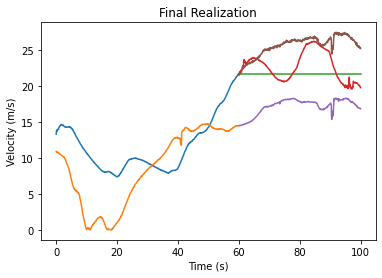

In [55]:
#Define the final realization
final_real_test = lead_testl - torch.Tensor(unnorm_pred)
constant_V = torch.ones(test_size, future_len)
for i in range(test_size):
    constant_V[i] = ego_test[i,-1]
#Prepare to plot the final realization
plt.plot(np.array(list(range(0,K)))/10,ego_test[sample], label = 'Ego Velocity (Input)')
plt.plot(np.array(list(range(0,K)))/10,lead_test[sample], label = 'Translated Lead Velocity')
plt.plot(np.array(list(range(K,K+future_len)))/10, constant_V[sample], label = 'Constant Velocity')
plt.plot(np.array(list(range(K,K+future_len)))/10,ego_testl[sample], label = 'Ego Truth' )
plt.plot(np.array(list(range(K,K+future_len)))/10,lead_testl[sample], label = 'Translated Lead Truth')
plt.plot(np.array(list(range(K,K+future_len)))/10, final_real_test[sample] , label = 'Prediction')  

# plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Final Realization')
plt.show()


#### Evaluation Metrics 

In [56]:
# Average Velocity Error Calculation
ts = 99 # time step at which we want to calculate VE
AVE_ml = np.mean(np.abs(np.array(ego_testl)-np.array(final_real_test)))
AVE_trans = np.mean(np.abs(np.array(ego_testl) - np.array(lead_testl)))
AVE_const = np.mean(np.abs(np.array(ego_testl) - np.array(constant_V)))
VE_const = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(constant_V[:,ts])))
VE_trans = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(lead_testl[:,ts])))
VE_ml = np.mean(np.abs(np.array(ego_testl[:,ts])-np.array(final_real_test[:,ts])))


print("VE ml at",ts, ':', VE_ml, "m/s")

ts = 199 # time step at which we want to calculate VE
VE_const = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(constant_V[:,ts])))
VE_trans = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(lead_testl[:,ts])))
VE_ml = np.mean(np.abs(np.array(ego_testl[:,ts])-np.array(final_real_test[:,ts])))
print("VE ml at",ts, ':', VE_ml, "m/s")

ts = 299 # time step at which we want to calculate VE
VE_const = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(constant_V[:,ts])))
VE_trans = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(lead_testl[:,ts])))
VE_ml = np.mean(np.abs(np.array(ego_testl[:,ts])-np.array(final_real_test[:,ts])))
print("VE ml at",ts, ':', VE_ml, "m/s")

ts = 399 # time step at which we want to calculate VE
VE_const = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(constant_V[:,ts])))
VE_trans = np.mean(np.abs(np.array(ego_testl[:,ts]) - np.array(lead_testl[:,ts])))
VE_ml = np.mean(np.abs(np.array(ego_testl[:,ts])-np.array(final_real_test[:,ts])))
print("VE ml at",ts, ':', VE_ml, "m/s")
print("AVE : ", AVE_ml, "m/s")

VE ml at 99 : 5.468997 m/s
VE ml at 199 : 6.3074985 m/s
VE ml at 299 : 7.1519995 m/s
VE ml at 399 : 8.981652 m/s
AVE :  6.037076 m/s


#### Velocity Error at Time Step

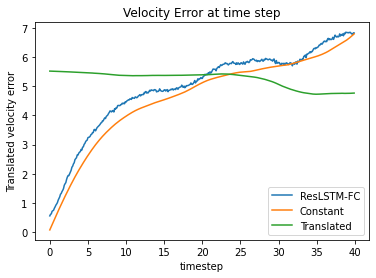

In [48]:
#Velocity at time step Error Calculation
VE_test = np.zeros(future_len)
VE_test_trans = np.zeros(future_len)
VE_constant = np.zeros(future_len)
time_step = list(range(0,future_len))

for i in range(future_len):
    VE_test[i] = np.mean(np.abs(np.array(ego_testl)[:,i]- np.array(final_real_test)[:,i]))
    VE_test_trans[i] = np.mean(np.abs(np.array(ego_testl)[:,i] - np.array(lead_testl)[:,i]))
    VE_constant[i] = np.mean(np.abs(np.array(ego_testl[:,i]) - np.array(constant_V[:,i])))
#Prepare to plot Testing Velocity Error  
plt.plot(np.array(time_step)/10, VE_test, label = 'ResLSTM-FC')
# plt.savefig("300K_20H_50FL_LR0005_test_VE")
plt.plot(np.array(time_step)/10, VE_constant, label = 'Constant')
#Prepare to plot Translated Velocity Error
plt.plot(np.array(time_step)/10, VE_test_trans, label = 'Translated')
plt.xlabel("timestep")
plt.ylabel("Translated velocity error")
plt.title("Velocity Error at time step")
plt.legend()
plt.show()

In [84]:
from scipy.io import savemat
mdict = {'ml_test_output':np.array(final_real_test), 'ego_test':np.array(ego_test), 'ego_truth': np.array(ego_testl), 'lead_shifted': np.array(lead_testl), 'lead_past': np.array(lead_test)}
savemat('ResLSTM-FC_table1_1.mat', mdict)